<a href="https://colab.research.google.com/github/Utree/deeplearning2_colab_log/blob/master/%EF%BC%96%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ゲート付きRNN

前章までのRNNをエルマン(Elman)と呼ぶ
エルマンは性能が良くない

問題点
- 時系列データの長期の依存関係を学習できないから

解決策
- 「ゲート」と呼ばれる仕組みを導入する
- ゲートを実装したRNNには、LSTMやGRUがある


## エルマンではなぜ、長期記憶が出来ないか？
- 勾配消失、勾配爆発が起こるから

## 勾配消失もしくは勾配爆発の原因
- 

In [0]:
import numpy as np
import matplotlib.pyplot as plt

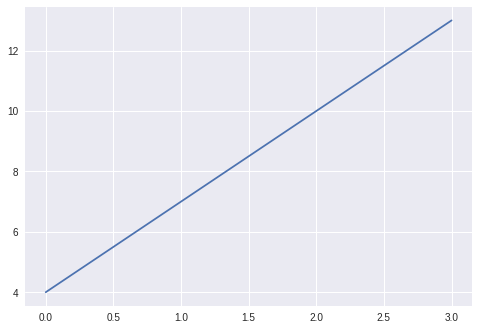

In [6]:
x = np.linspace(0, 3)
y = 3*x + 4

plt.plot(x, y, "-")
plt.show()

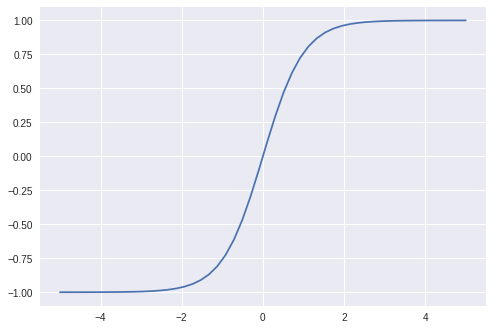

In [16]:
x1 = np.linspace(-5, 5)
y1 = np.tanh(x1)

plt.plot(x1, y1, "-")
plt.show()

In [0]:
# tanh関数の微分
def tanh_derivative(x):
  y = 4 / (np.exp(x) + np.exp(-x)) ** 2
  return y

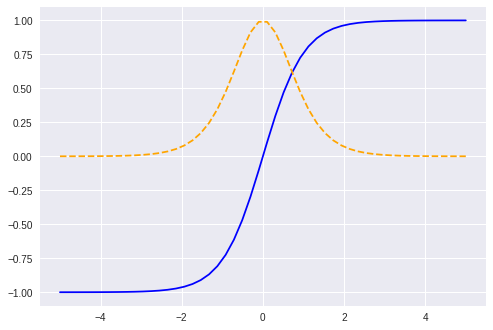

In [22]:
x2 = np.linspace(-5, 5)
y2 = tanh_derivative(x2)


plt.plot(x1, y1, color='blue',  linestyle='solid')
plt.plot(x2, y2, color='orange',  linestyle='dashed')
plt.show()

上記の式からも分かるように、
tanh(x)の微分の式では、xが0から遠ざかるにつれて、値が小さくなる。


MatMulノードの逆伝播では、時系列データの時間サイズ分だけ、毎回転置行列の積が掛けられる。

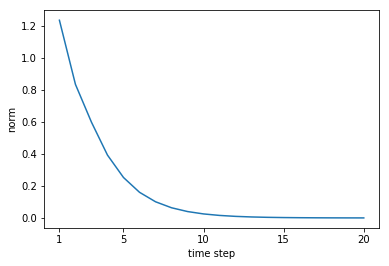

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # ミニバッチサイズ
H = 3 # 隠れ状態ベクトルの次元数
T = 20 # 時系列データの長さ

dh = np.ones((N, H))
np.random.seed(3) # 再現性のため乱数のシードを固定
# Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T)
  norm = np.sqrt(np.sum(dh**2)) / N 
  norm_list.append(norm)
  #   norm_list.append(dh)
  # dhは行列データなので、２乗の総和に平方根を適応して、平均値を求める

# print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

## L2ノルム
各要素の2乗の総和に平方根を適応したもの

逆伝播のMatMulノードの際、
勾配dhの大きさは重みWhの値によって指数的に、増加、減少する

※１より大きいとき、増加。１より小さい時減少

## 勾配爆発への対策
勾配爆発への対策は、勾配クリッピングという手法を用いる

## 勾配クリッピングでは、
勾配がしきい値以上のとき、勾配の値を

g = threshold / |g| * g

と設定する

つまり、勾配を±(しきい値)と設定する

## LSTMのインタフェース

RNN(エルマン)では、入力行列hとxをMatMulで抽出し、バイアスと一緒に足し合わせ、活性化関数tanhに通していた。

LSTMでも、入力行列hとx、バイアスをtanhに通す仕組みになっている。

エルマンとLSTMのインターフェースの違いは、記憶セル:cという経路があること

記憶セル:cには、過去から時刻tまでにおいて必要な情報が格納されている

記憶セル:cを用いて外部のレイヤへ状態hを出力する

記憶セル:cは 3つの入力(Ct-1, Ht-1, Xt)から何らかの計算によって、算出される

記憶セルCと隠れ状態Hの関係は
H = tanh(C)
である

## outputゲート
次時刻の隠れ状態としてどれだけ重要かを調整する

outputゲートの開き具合、次時刻へ状態hをどれだけ通すか?は次式の計算によって求める

o = o(xW + hW + b)

つまり、xWとhWとbの各要素の積によって、求める



## forgetゲート

何を忘れるかを明示的に指示するゲート

Ct-1の記憶から、不要な記憶を忘れさせるゲート



## アダマール積
数学におけるアダマール積は、同じサイズの行列に対して、成分ごとに積を取ることによって定まる行列の積

X: 各単語データ
H: 前時刻の状態
C: 記憶

## 新しい記憶gを生成するゲート
新しい情報を生成する

## inputゲート
新たに追加する情報(gの各要素)が、新しい情報として、どれだけ価値があるかを判断するゲート

## アファイン変換
平行移動と線形変換を組み合わせた変換のこと

具体的には拡大、縮小、剪断、回転、平行移動

In [0]:
# common/config.py

GPU = True

In [37]:
# common/np.py

# from common.config import GPU

if GPU:
  import cupy as np
  np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
  np.add.at = np.scatter_add
  
  print('\033[92m' + '-' * 60 + '\033[0m]')
  print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
  print('\033[92m' + '-' * 60 + '\033[0m\n]')
  
else:
  import numpy as np

------------------------------------------------------------]
                       GPU Mode (cupy)
------------------------------------------------------------
]


In [0]:
# common/optimizer.py

# from common.np import *

class SGD:
  '''
  確率的勾配降下法
  '''
  def __init__(self, lr=0.01):
    self.lr = lr
    
  def update(self, params, grads):
    for i in range(len(params)):
      params[i] -= self.lr * grads[i]

In [0]:
# common/util.py
import os

def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad ** 2)
  total_norm = np.sqrt(total_norm)
  
  rate = max_norm / (total_norm + 1e-6)
  if rate < 1:
    for grad in grads:
      grad *= rate
      
def eval_perplexity(model, corpus, batch_size=10, time_size=35):
  print('evaluating perplexity ...')
  corpus_size = len(corpus)
  total_loss, loss_cnt = 0, 0
  max_iters = (corpus_size - 1) // (batch_size * time_size)
  jump = (corpus_size - 1) // batch_size
  
  for iters in range(max_iters):
    xs = np.zeros((batch_size, time_size), dtype=np.int32)
    ts = np.zeros((batch_size, time_size), dtype=np.int32)
    time_offset = iters * time_size
    offsets = [time_offset + (i * jump) for i in range(batch_size)]
    for t in range(time_size):
      for i, offset in enumerate(offsets):
        xs[i, t] = corpus[(offset + t) % corpus_size]
        ts[i, t] = corpus[(offset + t + 1) % corpus_size]
        
    try:
      loss = model.forward(xs, ts, train_flg=False)
    except TypeError:
      loss = model.forward(xs, ts)
    total_loss += loss
    
    sys.stdout.write('\r%d / %d' % (iters, max_iters))
    sys.stdout.flush()
    
  print('')
  ppl = np.exp(total_loss / max_iters)
  return ppl

def to_cpu(x):
  import numpy
  if type(x) == numpy.ndarray:
    return x
  return np.asnumpy(x)

def to_gpu(x):
  import cupy
  if type(x) == cupy.ndarray:
    return x
  return cupy.asarray(x)

In [0]:
# common/trainer.py

import numpy
import time
import matplotlib.pyplot as plt
# from common.np import *
# from common.util import clip_grads

class RnnlmTrainer:
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer
    self.time_idx = None
    self.ppl_list = None
    self.eval_interval = None
    self.current_epoch = 0
    
  def get_batch(self, x, t, batch_size, time_size):
    batch_x = np.empty((batch_size, time_size), dtype='i')
    batch_t = np.empty((batch_size, time_size), dtype='i')
    
    data_size = len(x)
    jump = data_size // batch_size
    offsets = [i * jump for i in range(batch_size)] # バッチの各サンプルの読み込み開始位置
    
    for time in range(time_size):
      for i, offset in enumerate(offsets):
        batch_x[i, time] = x[(offset + self.time_idx) % data_size]
        batch_t[i, time] = t[(offset + self.time_idx) % data_size]
      self.time_idx += 1
    return batch_x, batch_t
  
  def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35, max_grad=None, eval_interval=20):
    data_size = len(xs)
    max_iters = data_size // (batch_size * time_size)
    self.time_idx = 0
    self.ppl_list = []
    self.eval_interval = eval_interval
    model, optimizer = self.model, self.optimizer
    total_loss = 0
    loss_count = 0
    
    start_time = time.time()
    for epoch in range(max_epoch):
      for iters in range(max_iters):
        batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)
        
        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        params, grads = remove_duplicate(model.params, model.grads)
        # 共有された重みを1つに集約
        if max_grad is not None:
          clip_grads(grads, max_grad)
        optimizer.update(params, grads)
        total_loss += loss
        loss_count += 1
        
        # パープレキシティの評価
        if (eval_interval is not None) and (iters % eval_interval) == 0:
          ppl = np.exp(total_loss / loss_count)
          elapsed_time = time.time() - start_time
          print('| epoch %d | iter %d / %d | time %d[s] | perplexity %.2f' % (self.current_epoch + 1, iters + 1,  max_iters, elapsed_time, ppl))
          self.ppl_list.append(float(ppl))
          total_loss, loss_count = 0, 0
      
      self.current_epoch += 1
      
  def plot(self, ylim=None):
    x = numpy.arange(len(self.ppl_list))
    if ylim is not None:
      plt.ylim(*ylim)
    plt.plot(x, self.ppl_list, label='train')
    plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
    plt.ylabel('perplexity')
    plt.show()
    
def remove_duplicate(params, grads):
  '''
  パラメータ配列中の重複する重みを一つに集約し、
  その重みに対応する勾配を加算する
  '''
  params, grads = params[:], grads[:] # copy list
  
  while True:
    find_flg = False
    L = len(params)
    
    for i in range(0, L - 1):
      for j in range(i + 1, L):
        # 重みを共有する場合
        if params[i] is params[j]:
          grads[i] += grads[j] # 勾配の加算
          find_flg = True
          params.pop(j)
          grads.pop(j)
        # 転置行列として重みを共有する場合 (weight tying)
        elif params[i].ndim == 2 and params[j].ndim == 2 and params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
          grads[i] += grads[j].T
          find_flg = True
          params.pop(j)
          grads.pop(j)
          
        if find_flg: break
      if find_flg: break
      
    if not find_flg: break
    
  return params, grads

In [0]:
# dataset/ptb.py

# coding: utf-8
import sys
import os
sys.path.append('..')
try:
    import urllib.request
except ImportError:
    raise ImportError('Use Python3!')
import pickle
import numpy as np


url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

dataset_dir = os.path.dirname(os.path.abspath("__file__"))


def _download(file_name):
    file_path = dataset_dir + '/' + file_name
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')


def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word


def load_data(data_type='train'):
    '''
        :param data_type: データの種類：'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val': data_type = 'valid'
    save_path = dataset_dir + '/' + save_file[data_type]

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name
    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word


if __name__ == '__main__':
    for data_type in ('train', 'val', 'test'):
        load_data(data_type)


In [0]:
# common/functions.py

# from common.np import *


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


In [0]:
# common/layers.py

# from common.np import *  # import numpy as np
# from common.config import GPU
# from common.functions import softmax, cross_entropy_error


class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None


In [0]:
# common/time_layer.py

# from common.np import *  # import numpy as np (or import cupy as np)
# from common.layers import *
# from common.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask


class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

# ====================================================================== #
# 以下に示すレイヤは、本書で説明をおこなっていないレイヤの実装もしくは
# 処理速度よりも分かりやすさを優先したレイヤの実装です。
#
# TimeSigmoidWithLoss: 時系列データのためのシグモイド損失レイヤ
# GRU: GRUレイヤ
# TimeGRU: 時系列データのためのGRUレイヤ
# BiTimeLSTM: 双方向LSTMレイヤ
# Simple_TimeSoftmaxWithLoss：単純なTimeSoftmaxWithLossレイヤの実装
# Simple_TimeAffine: 単純なTimeAffineレイヤの実装
# ====================================================================== #


class TimeSigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.xs_shape = None
        self.layers = None

    def forward(self, xs, ts):
        N, T = xs.shape
        self.xs_shape = xs.shape

        self.layers = []
        loss = 0

        for t in range(T):
            layer = SigmoidWithLoss()
            loss += layer.forward(xs[:, t], ts[:, t])
            self.layers.append(layer)

        return loss / T

    def backward(self, dout=1):
        N, T = self.xs_shape
        dxs = np.empty(self.xs_shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t] = layer.backward(dout)

        return dxs


class GRU:
    def __init__(self, Wx, Wh):
        '''

        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（3つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（3つ分の重みをまとめる）
        '''
        self.Wx, self.Wh = Wx, Wh
        self.dWx, self.dWh = None, None
        self.cache = None

    def forward(self, x, h_prev):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next

    def backward(self, dh_next):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        # tanh
        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        # update gate(z)
        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        # rest gate(r)
        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        self.dWx = np.hstack((dWxz, dWxr, dWx))
        self.dWh = np.hstack((dWhz, dWhr, dWh))

        return dx, dh_prev


class TimeGRU:
    def __init__(self, Wx, Wh, stateful=False):
        self.Wx, self.Wh = Wx, Wh
        selfdWx, self.dWh = None, None
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        N, T, D = xs.shape
        H, H3 = self.Wh.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(self.Wx, self.Wh)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        N, T, H = dhs.shape
        D = self.Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        self.dWx, self.dWh = 0, 0

        dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)

            dxs[:, t, :] = dx
            self.dWx += layer.dWx
            self.dWh += layer.dWh

        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class Simple_TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape
        layers = []
        loss = 0

        for t in range(T):
            layer = SoftmaxWithLoss()
            loss += layer.forward(xs[:, t, :], ts[:, t])
            layers.append(layer)
        loss /= T

        self.cache = (layers, xs)
        return loss

    def backward(self, dout=1):
        layers, xs = self.cache
        N, T, V = xs.shape
        dxs = np.empty(xs.shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = layers[t]
            dxs[:, t, :] = layer.backward(dout)

        return dxs


class Simple_TimeAffine:
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.dW, self.db = None, None
        self.layers = None

    def forward(self, xs):
        N, T, D = xs.shape
        D, M = self.W.shape

        self.layers = []
        out = np.empty((N, T, M), dtype='f')
        for t in range(T):
            layer = Affine(self.W, self.b)
            out[:, t, :] = layer.forward(xs[:, t, :])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, M = dout.shape
        D, M = self.W.shape

        dxs = np.empty((N, T, D), dtype='f')
        self.dW, self.db = 0, 0
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t, :] = layer.backward(dout[:, t, :])

            self.dW += layer.dW
            self.db += layer.db

        return dxs


In [0]:
# common/base_model.py

import os
import pickle
# from common.np import *
# from common.util import to_gpu, to_cpu


class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]


In [0]:
# ch06/rnnlm.py

# from common.time_layer import *
# from common.base_model import BaseModel

class Rnnlm(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn
    
    # 重みの初期化
    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4 * H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')
    
    # レイヤの生成
    self.layers = [
        TimeEmbedding(embed_W),
        TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
        TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]
    
    # すべての重みと勾配をリストにまとめる
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
    
  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return  xs
  
  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout
  
  def reset_state(self):
    self.lstm_layer.reset_state()

In [0]:
# ch06/train_rnnlm.py

# from common.optimizer import SGD
# from common.trainer import RnnlmTrainer
# from common.util import eval_preplexity
# from dataset import ptb
# from rnnlm import Rnnlm

# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態ベクトルの要素数
time_size = 35 # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = load_data('train')
corpus_text, _, _ = load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適応して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

## LSTMの勾配の流れ
LSTMで、記憶セルcの順伝播では、+とxノードだけを通り、行列の積ではなく、アダマール積(各要素ごとの積)が行われているので、劣化が起こりにくくなっている

また、積の計算を行っているforgetゲートでは、忘れてはいけないと導いた要素に対して、劣化することなく過去方向へ伝わるので、勾配消失を起こさず伝播することが期待できる

## RNNLMの改善
- 多層化
LSTMレイヤを重ねることで、精度向上が期待できる
- Dropoutによる過学習の抑制
- 重み共有　(EmbeddingレイヤとAffineレイヤの重みを結びつける(共有する))

## 正則化
モデルの複雑さにペナルティーを与えること

過学習を抑制する目的で行う

e.x)
- 重みが大きくなりすぎることにペナルティーを課す(L2正則化)
- ニューロンのいくつかをランダムに無視して学習を行う(Dropout)

RNNLMでは、時間方向(左右)ではなく、深さ方向(上下)にDropoutを適応している

ノイズの蓄積を考慮したため。

しかし、変分Dropoutでは、時間方向への適応に成功している

## 重み共有
Embeddingレイヤの重みとAffineレイヤの重みを結びつける(共有する)テクニック

学習するパラメータを削減でき、
精度も向上する

なぜ？-> 論文参照
